In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Create `Field2D` class

Simplest field possible, an $n\times n$ grid that calculates distance using the Pythagorean theorem.  
Use this as a blueprint for more complicated (network-based) classes.

In [2]:
class Field2D():
    # create a 2D grid to find weights and distances on

    cost_est = None
    weights = None 
    res = 1

    def __init__(self, xsize, ysize, init_cost=10, res=1):
        '''
        initialize cost estimate grid and weight grid
        '''
        # TODO: tweakable resolution?
        self.cost_est = np.ones([xsize, ysize])*init_cost
        self.weights = np.ones([xsize, ysize])
        self.res = res
    
    def get_dist(self, loc1, loc2):
        '''
        get distance between two locs
        '''
        return ((loc2[0] - loc1[0])**2 + (loc2[1] - loc1[1])**2)**(1/2)
    
    def cmask(self, loc, radius):
        '''
        get all IDs within a given radius (after normalization to indices) of loc
        '''
        radius_normalized = radius/self.res
        a,b = loc
        nx,ny = self.weights.shape
        y,x = np.ogrid[-a:nx-a,-b:ny-b]
        x,y = np.where(x*x + y*y <= radius_normalized*radius_normalized)
        return set([(x[i],y[i]) for i in range(len(x))])
    
    def set_loc(self, loc, cost_est=None, weight=None):
        '''
        set the cost estimate and weight at a location to new values
        '''
        pass

        if cost_est:
            self.cost_est[loc] = cost_est
        if weight:
            self.weights[loc] = weight

## test `Field2D`

Instantiate a `Field2D` and verify that the distance function is working as intended.

In [3]:
testfield = Field2D(10,10)
print(testfield.get_dist((0,0),(0,10)))
print(testfield.get_dist((0,0),(10,0)))
print(testfield.get_dist((0,0),(10,10)))

10.0
10.0
14.142135623730951


# Create `BackhaulEstimator`

Works with any class that follows the `Field2D` prototype.

Given a newly resolved shipping request containing (origin coordinates `loc1`, destination coordinates `loc2`, offer price `price`, and whether or not the request was accepted `accepted`), the estimate and weight algorithm proceeds as follows:
1. Estimate `cost`, the portion of `price` allocated to traveling to `loc1` or from `loc2` by subtracting the cost to travel between `loc1` and `loc2` and dividing by 2.
    1. If `cost` is less than zero, set to zero in order not to break subsequent steps with negative numbers.
2. Calculate area of effect `radius` by tranforming `cost` to distance units by some constant factor `__b`.
3. Identify the set of coordinates within 1 `radius` distance of `loc1` or `loc2` as `inner` and the set of coordinates outside of 1 `radius` but within 2 `radius` as `outer`. Compile corresponding distances outside of 1 `radius` for every coordinate in `outer`, normalized to between `[0,1]`.
4. Update cost estimates and weights for every coordinate `loc` in `inner` or `outer` if the request was accepted OR the offered price was higher than the estimated cost (even though the request was rejected).
    1. Update cost estimate `cost_est` at coordinate `loc`, moving toward observed cost `cost` from current estimate `c_hat` according to the current weight `w`. $\text{cost_est} = w \times \text{cost} + (1-w)\times\text{c_hat}$ 
    2. If coordinate is in `outer`, reduce update by further moving estimate back toward `c_hat` according to the normalized distance of coordinate outside of inner circle `d` $\in [0,1]$. $\text{cost_est} = (1-d) \times \text{cost_est} + (d)\times\text{c_hat}$ 
    3. Update the weight `w` using a normal or more aggressive method depending on whether the request was accepted or not.

In [4]:
class BackhaulEstimator:
    '''
    create a prototype that can handle distances in either a 2D grid or a road network
    concrete implementations of Field need to follow the prototype set by the `Field2D` class
    '''

    __b = 10 # base cost per mile in $/mi

    def __init__(self, 
                 field, 
                 weight_fcn=(lambda w,d: w/(1+.001*(1-d))), 
                 weight_fcn_aggressive=(lambda w,d: w/(1+.001*(1-d)))):
        '''
        pass an object following the Field2D prototype
        weight functions decide how field weights will be updated when new information is received
        '''
        self.field = field
        self.weight_fcn = weight_fcn
        self.weight_fcn_aggressive = weight_fcn_aggressive
    
    def __get_radial_area(self, loc, radius):
        '''
        get list of indices that can be used to identify grid locations/nodes and their distance to the loc
        '''

        # get mask
        inner = self.field.cmask(loc, radius)
        outer = self.field.cmask(loc, 2*radius).difference(inner)
        
        # create dict for outer points of their normalized distance from the circle
        outer_dists = {k: (self.field.get_dist(loc, k) - radius)/radius for k in outer}
        
#         # TODO: remove after testing
#         # plot inner and outer circles to verify accuracy
#         plt.scatter([x[0] for x in inner], [x[1] for x in inner], c='red')
#         plt.scatter([x[0] for x in outer], [x[1] for x in outer], c='orange')
#         plt.ylim(0,self.field.weights.shape[0])
#         plt.xlim(0,self.field.weights.shape[0])
#         plt.show()
        
        return inner, outer, outer_dists
    
    def __update_index(self, loc, cost, accepted, d=0):
        '''
        update estimated cost and weight at a specific index based on a resolved request's cost and acceptance status 
        '''
        c_hat = self.field.cost_est[loc]
        w = self.field.weights[loc]

#         # calc alpha coeff to decay effect outside of inner area.
#         # note d is normalized distance outside of inner circle from [0,1]
#         alpha = d #(d*self.__b/cost)

        # initial cost estimate based on mixing current cost estimate and new observed cost based on weight
        # note weights are within [0,1]
        cost_est = (w)*cost + (1-w)*c_hat
        if d > 0: # decay influence of new observed cost outside of inner circle
            cost_est = (1-d)*cost_est + d*c_hat
        # this is equivalent to the following
        # cost_est = (1-d)*(w)*cost + (1 - w + d*w)*c_hat

        # make current cost estimate stickier
        if accepted:
            weight = self.weight_fcn(self.field.weights[loc],d)
        elif (cost > c_hat):
            weight = self.weight_fcn_aggressive(self.field.weights[loc],d)
        
            self.field.set_loc(loc, cost_est, weight)
    
    def __get_rec_range(self, loc1, loc2):
        '''
        recommend pricing range that trades off between likelihood of acceptance and 
        gathering additional information about area of study. returns length 2 array.
        '''
        # TODO
        range = [0,0]
        return range

    def get_cost_est(self, loc1, loc2):
        '''
        calculate estimated cost of delivery with cost of getting to loc1, leaving loc2, and travel dist
        '''        
        # TODO: consider factoring in cost of getting paid to get closer to depot(?)        
        return self.field.cost_est[loc1] + self.field.cost_est[loc2] + self.field.get_dist(loc1, loc2)*self.__b

    def update_est(self, loc1, loc2, price, accepted):
        '''
        update estimates in areas affected by new offer resolution
        '''
        cost = (price - self.__b*self.field.get_dist(loc1, loc2))/2
        if cost < 0:
            # undervalued cost, breaks equation.
#             print(self.__b*self.field.get_dist(loc1, loc2))
#             print('cost {} shouldn\'t be less than zero. setting cost to 0.'.format(cost))
            cost = 0

        # get radial areas around loc1 and loc2 and reconcile the overlap
        radius = cost/self.__b
        inner1, outer1, outer_dists1 = self.__get_radial_area(loc1, radius)
        inner2, outer2, outer_dists2 = self.__get_radial_area(loc2, radius)
        inner1.update(inner2)
        inner = inner1
        outer1.update(outer2)
        outer = outer1
        outer.difference_update(inner)

        # merge outer_dists dictionaries, removing entries in inner and taking minimum dist in case of overlap
        outer_dists = {}
        for k in outer:
            dists = []
            if k in outer_dists1:
                dists.append(outer_dists1[k])
            if k in outer_dists2:
                dists.append(outer_dists2[k])
            outer_dists[k] = min(dists)

        # update cost estimate and weights in affected areas
        for loc in inner:
            self.__update_index(loc, cost, accepted)
            
#         # TODO: remove after debugging
#         # plot weight fields after updating inner section 
#         a = plt.contourf(self.field.weights.T)
#         plt.colorbar(a)
#         plt.title('weights after inner update')
#         plt.show()

        for loc in outer:
            self.__update_index(loc, cost, accepted, d=outer_dists[loc])

#         # TODO: remove after debugging
#         # plot weight fields after updating inner and outer sections
#         a = plt.contourf(self.field.weights.T)
#         plt.colorbar(a)
#         plt.title('weights after full update')
#         plt.show()
    
    def get_recommended_cost(self, loc1, loc2):
        '''
        convenience function to yield a single price from the estimate and info range
        aiming to maximize the likelihood of a match first, then info gathering
        if est in range, return est
        if est below range, return est
        if est above range, return range high
        '''

        est = self.get_cost_est(loc1, loc2)
        rng = self.__get_rec_range(loc1, loc2)

        if est < rng[1]:
            return est
        else:
            return rng[1]

## Testing `BackhaulEstimator`

Start by instantiating the test field and plotting the (supposedly empty) field and an assumption (for testing purposes) that our truck is moving from (9,9) to (0,0) originally.

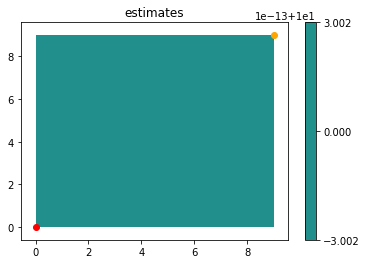

In [5]:
testfield = Field2D(10,10)
be = BackhaulEstimator(testfield)

# convenience function for plotting
def plot_field(field, og, dt, estimates=True, vmin=0, vmax=100):
    a=plt.contourf(field.cost_est if estimates else field.weights, vmin=vmin, vmax=vmax)
    plt.colorbar(a)
    plt.scatter(og[0], og[1], color='orange')
    plt.scatter(dt[0], dt[1], color='red')
    plt.title('estimates' if estimates else 'weights')
    plt.show()
plot_field(testfield, og=(9,9), dt=(0,0), vmin=0, vmax=20)

Update with our first request, an accepted movement from (4,5) to (5,4) at 50 revenue units.  
Sanity check both contour plot and raw values for both cost estimates and weights.

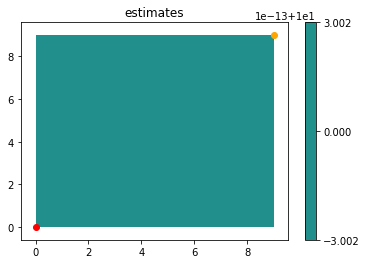

In [6]:
be.update_est((4,5),(5,4),50,True)

plot_field(testfield, og=(9,9), dt=(0,0), vmin=0, vmax=20)

In [7]:
print(testfield.cost_est)

[[10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]]


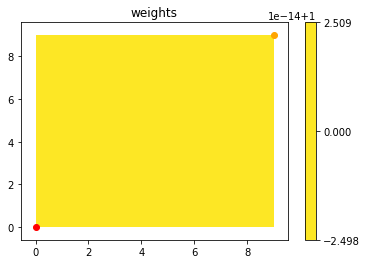

In [8]:
plot_field(testfield, og=(9,9), dt=(0,0), estimates=False, vmin=0.99, vmax=1)

In [9]:
print(testfield.weights)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


Add a few more movements based on the idea that the trucks original origin and destination are around the top right (9,9) and bottom left (0,0), respectively.

First, a path longer, perpendicular to, and cheaper than the first movement that aligns with the original origin/destination path.

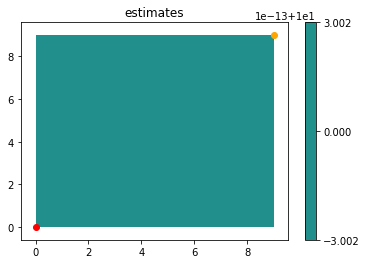

In [10]:
be.update_est((6,6),(3,3),60,True)

plot_field(testfield, og=(9,9), dt=(0,0), vmin=0, vmax=20)

Next a rejected request.

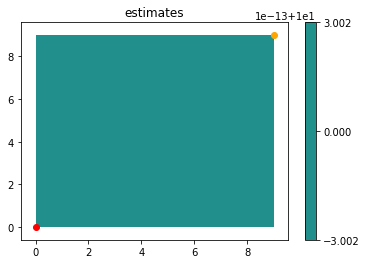

In [11]:
be.update_est((6,3),(3,6),50,False)

plot_field(testfield, og=(9,9), dt=(0,0), vmin=0, vmax=20)

Finally a long and expensive rejected request intended to raise estimated costs on the fringe.

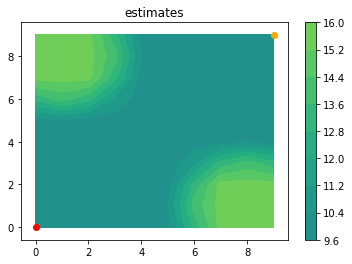

In [12]:
be.update_est((1,8),(8,1),130,False)

plot_field(testfield, og=(9,9), dt=(0,0), vmin=0, vmax=20)

## Randomized, programmatic testing

Now that we've verified that custom-drawn paths work, let's design a testing procedure with random elements that can create randomized requests.

Procedure as follows:
1. Create a square `Field2D` of some `size` and a corresponding `BackhaulEstimator` with some `weight_fcn` and `weight_fcn_aggressive`. Initialize current origin `og` to input `org`.
2. Start accepted requests counter `i` and consequetive rejected requests counter `r` at 0. While `i` is less than input `n`,
    1. Calculate the cost `curcost` to get from current origin `og` to the global endpoint, the input `depot`.
    2. Randomly generate shipping request origin and destination coordinates `rog` and `rdt` from the uniform distribution between `[0,size]`.
    3. Calculate `mincost`, the bare cost to travel from `rog` to `rdt` without accounting for getting from current `og` to `rog` or `rdt` to `depot`.
    4. Generate a price offer `rev` for the request by taking `mincost` and adding a random term scaled between a minimum and maximum distance `random_range` specified by an input
    5. Calculate the actual cost of fulfilling the shipping request by taking `mincost` and adding the cost of traveling from `og` to `rog` and from `rdt` to `depot`.
    6. Check if the carrier will profit from accepting the request, i.e. if the revenue `rev` is greater than the additional cost of accepting the request `ofcost - curcost`.
        1. If so, accept the request, update cost estimates and weights accordingly, and increment the accepted requests counter `i`.
        2. If not, reject the request, update cost estimates and weights accordingly, and increment the consecutive rejected requests counter `r`.
            1. If `r` has reached input `rlim`, reset `r=0` and `og` to the original origin `ogorg`.
    7. For every input `progress_plot_interval` number of requests and when the rejected requests counter `r` is at zero, output a progress plot of the current weight estimates.

Estimated, offered, real cost 100.0 55.04103051391902 86.28326057066968
rejected (9, 12) (1, 12) 55.04103051391902
Estimated, offered, real cost 92.80109889280519 117.99533259061872 74.80591813216893
accepted (13, 4) (6, 2) 117.99533259061872


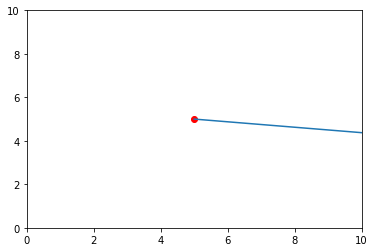

Estimated, offered, real cost 110.55385138137417 55.812353780052966 225.755359455617
rejected (12, 17) (13, 8) 55.812353780052966
Estimated, offered, real cost 120.0 60.33177532287758 210.58909592404967
rejected (12, 17) (4, 11) 60.33177532287758
Estimated, offered, real cost 122.95630140987001 134.54543522543278 224.44474943616433
rejected (18, 16) (9, 11) 134.54543522543278
Estimated, offered, real cost 181.55494421403512 151.67172337402667 242.93919143678636
rejected (12, 17) (6, 2) 151.67172337402667
resetting OD


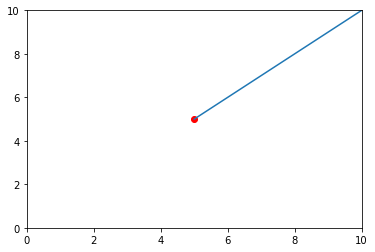

Estimated, offered, real cost 150.384048104053 225.37606382887932 272.51075213957193
rejected (4, 6) (3, 19) 225.37606382887932
Estimated, offered, real cost 130.51670332882193 35.39830790378199 127.71456742700985
rejected (3, 16) (8, 14) 35.39830790378199
Estimated, offered, real cost 197.48811171144405 211.37612418274398 271.17968256883154
rejected (8, 9) (19, 17) 211.37612418274398
Estimated, offered, real cost 147.2898398246727 166.8619968311712 77.18077567870546
accepted (11, 3) (5, 7) 166.8619968311712


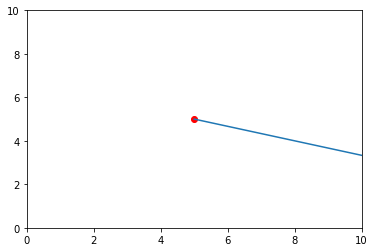

Estimated, offered, real cost 146.00259382011203 63.10035058047301 118.29275021826936
rejected (7, 6) (6, 12) 63.10035058047301
Estimated, offered, real cost 263.6512891432962 213.81694650391864 445.31926736352517
rejected (5, 19) (18, 3) 213.81694650391864
resetting OD


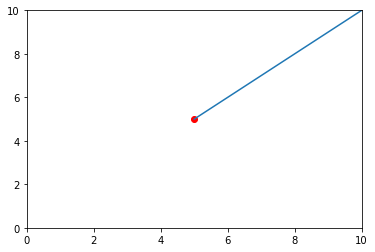

Estimated, offered, real cost 294.43645811291486 260.7120682302665 451.2905930373661
rejected (7, 0) (19, 19) 260.7120682302665
Estimated, offered, real cost 268.57934172380055 178.64290472499115 371.38979676963754
rejected (4, 3) (15, 18) 178.64290472499115
Estimated, offered, real cost 170.69888372985838 90.16495724071765 108.8811766672344
rejected (17, 18) (8, 17) 90.16495724071765
Estimated, offered, real cost 224.2909322550977 128.01722104858686 262.0260591226672
rejected (9, 1) (1, 14) 128.01722104858686
Estimated, offered, real cost 152.1744988150893 189.94218034360773 203.20989161438524
rejected (16, 7) (11, 18) 189.94218034360773
resetting OD


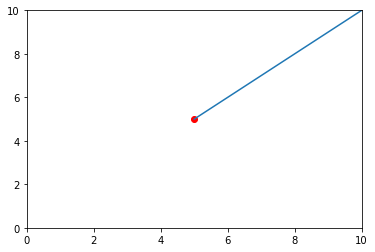

Estimated, offered, real cost 164.2650648272655 183.75386220453882 114.46725710414916
accepted (18, 3) (9, 5) 183.75386220453882


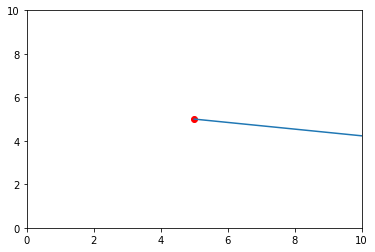

Estimated, offered, real cost 189.10187369086918 138.96798743037084 238.56319427509627
rejected (13, 19) (13, 7) 138.96798743037084
Estimated, offered, real cost 117.35269549982422 71.06233132618652 66.21850598504076
accepted (2, 5) (4, 6) 71.06233132618652


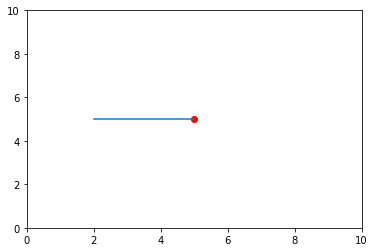

Estimated, offered, real cost 108.3916957569923 67.23852397513016 300.02627421827833
rejected (13, 14) (11, 18) 67.23852397513016
Estimated, offered, real cost 215.36061474174622 245.26667754437926 379.03032415066843
rejected (11, 18) (12, 1) 245.26667754437926
Estimated, offered, real cost 252.51023168759733 236.52439421076772 409.58923021340416
rejected (14, 8) (1, 19) 236.52439421076772
Estimated, offered, real cost 206.96395180519082 112.90417765541014 305.825203124494
rejected (14, 2) (0, 0) 112.90417765541014
resetting OD


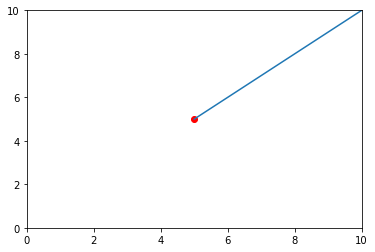

Estimated, offered, real cost 128.73282408028297 50.02075349479039 195.06431105992164
rejected (19, 3) (18, 10) 50.02075349479039
Estimated, offered, real cost 191.28154389527418 122.67478642710269 255.09630178532944
rejected (5, 1) (16, 2) 122.67478642710269
Estimated, offered, real cost 157.3998333923517 63.13103753279315 64.89240434638873
rejected (8, 15) (10, 7) 63.13103753279315
Estimated, offered, real cost 132.0331474833261 119.61314064432372 146.28193990538057
rejected (15, 3) (15, 9) 119.61314064432372
Estimated, offered, real cost 246.5369887508734 194.25009681619446 325.8539205488515
rejected (3, 3) (9, 18) 194.25009681619446
resetting OD


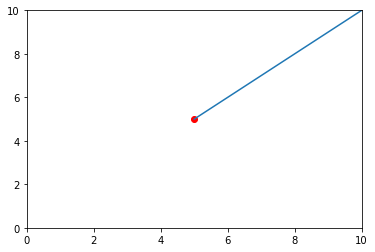

Estimated, offered, real cost 196.78428403801541 102.87200225530883 147.85891162962935
rejected (13, 1) (2, 3) 102.87200225530883
Estimated, offered, real cost 183.1983331151638 152.8284001749244 215.79109883407034
rejected (16, 6) (15, 17) 152.8284001749244
Estimated, offered, real cost 142.2412161609662 52.04548527410535 115.49966641579624
rejected (13, 2) (10, 8) 52.04548527410535
Estimated, offered, real cost 204.34923271056925 170.6883730029573 173.6347095435127
rejected (4, 18) (12, 9) 170.6883730029573
Estimated, offered, real cost 218.39444004154421 186.26357443581583 273.0283545603943
rejected (0, 18) (13, 15) 186.26357443581583
resetting OD


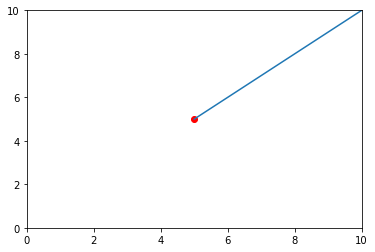

Estimated, offered, real cost 110.35106711310092 127.88028145333703 24.74551113697521
accepted (12, 16) (9, 14) 127.88028145333703


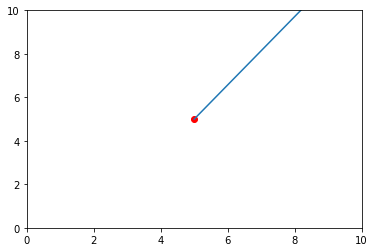

Estimated, offered, real cost 187.8668810757806 60.8990069563402 76.31419740475377
rejected (17, 11) (7, 7) 60.8990069563402
Estimated, offered, real cost 221.33575093808537 167.2242943380936 291.8002402397235
rejected (4, 2) (17, 7) 167.2242943380936
Estimated, offered, real cost 137.35416910605338 56.046073802828275 166.81773642133695
rejected (12, 6) (17, 1) 56.046073802828275
Estimated, offered, real cost 99.93738696872828 41.502402857275484 9.3727994688509
accepted (11, 10) (9, 9) 41.502402857275484


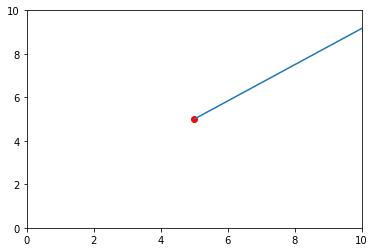

Estimated, offered, real cost 166.02089108204817 64.07191669361353 183.41166319939663
rejected (19, 9) (10, 12) 64.07191669361353
Estimated, offered, real cost 215.27415835912632 153.60422083577302 269.378890888841
rejected (2, 6) (8, 17) 153.60422083577302
resetting OD


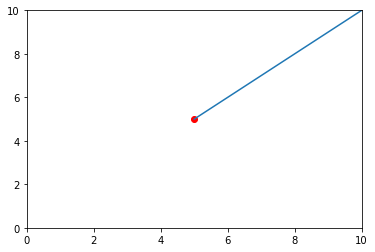

Estimated, offered, real cost 191.39819703173157 187.12508466409665 106.28193990538057
accepted (15, 15) (5, 19) 187.12508466409665


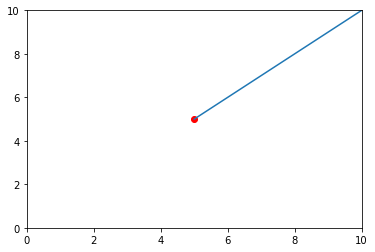

Estimated, offered, real cost 177.45412823717953 69.27085977382634 201.0407562750437
rejected (3, 10) (5, 18) 69.27085977382634
Estimated, offered, real cost 169.14749895774855 61.79590919786798 212.37008456058004
rejected (4, 13) (12, 18) 61.79590919786798
Estimated, offered, real cost 165.70690627659872 60.64353836697711 76.41171575764321
rejected (10, 10) (9, 1) 60.64353836697711
Estimated, offered, real cost 176.7257434356846 134.34141633370103 256.82722573710475
rejected (13, 1) (19, 10) 134.34141633370103
Estimated, offered, real cost 189.16552741643198 95.9695323258293 143.1708587289449
rejected (11, 7) (0, 11) 95.9695323258293
resetting OD


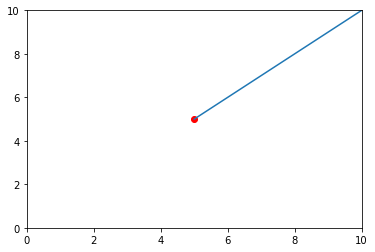

Estimated, offered, real cost 196.96391530030832 153.08336014546578 164.55967749237004
rejected (16, 14) (19, 0) 153.08336014546578
Estimated, offered, real cost 252.36022182146954 137.6036607906748 187.21596752935915
rejected (19, 19) (14, 2) 137.6036607906748
Estimated, offered, real cost 179.706064839001 129.65717136717254 145.96161602154598
rejected (0, 13) (8, 7) 129.65717136717254
Estimated, offered, real cost 262.08059070514224 269.5686597913549 73.78097513969374
accepted (16, 15) (3, 3) 269.5686597913549


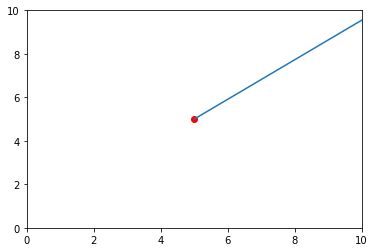

Estimated, offered, real cost 105.4723334310963 112.73633593143892 63.91277965881301
accepted (12, 6) (13, 3) 112.73633593143892


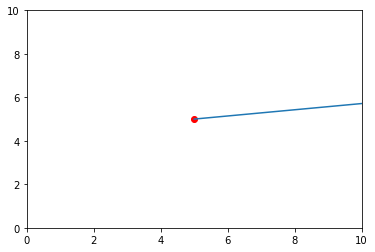

Estimated, offered, real cost 100.25671706540338 -31.049592188037067 14.010681431341041
rejected (9, 6) (9, 7) -31.049592188037067
Estimated, offered, real cost 156.27359673468675 165.0387037152152 122.998747271176
accepted (6, 0) (8, 7) 165.0387037152152


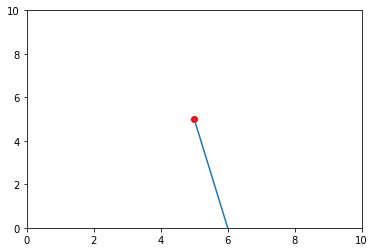

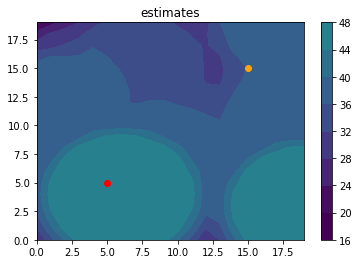

In [13]:
def big_tester(size, n, rlim, ogorg, depot, random_range, weight_fcn, weight_fcn_aggressive, progress_plot_interval=500, debug=False):
    '''
    randomly generate resolved requests and feed them to a BackhaulEstimator with a size^2 Field2Duntil we hit n requests accepted.
    size: length of each edge of the Field2D grid
    n: number of requests to accept before ending the test session
    rlim: number of consecutive requests rejected until the origin is reset to ogorg 
    ogorg: carrier's original origin coordinates
    depot: carrier's depot (final destination)
    random_range: [min, max] additional value (in distance units, to be scaled by a distance-to-cost factor) added to the cost of fulfilling a shipping request (with considering travel to/away from the request)
    weight_fcn, weight_fcn_aggressive: weight updating functions provided to BackhaulEstimator
    progress_plot_interval: how often to output a current-estimate contour plot, by units of requests accepted
    debug: whether or not to show progress messages and plots
    '''

    testfield = Field2D(size,size)
    be = BackhaulEstimator(
            testfield, 
            weight_fcn = weight_fcn, 
            weight_fcn_aggressive = weight_fcn_aggressive
            )

    i = 0 # requests accepted
    r = 0 # requests rejected since last reassignment

    og = ogorg

    while i < n:

        # calc current cost to return to depot
        curcost = testfield.get_dist(og, depot)*be._BackhaulEstimator__b

        # randomly generate an OD pair
        rog = (np.random.randint(size), np.random.randint(size))
        rdt = (np.random.randint(size), np.random.randint(size))

        # calculate minimum cost of transporting
        mincost = testfield.get_dist(rog, rdt)*be._BackhaulEstimator__b

        # add random addtl revenue to cover cost of travel
        rev = mincost + (np.random.rand()*(random_range[1]-random_range[0]) + random_range[0])*be._BackhaulEstimator__b

        # calc true cost to fulfill request then return to depot
        ofcost = (testfield.get_dist(og, rog) + testfield.get_dist(rog, rdt) + testfield.get_dist(rdt, depot))*be._BackhaulEstimator__b

        # est cost, offered cost, real cost 
        if debug:
            print('Estimated, offered, real cost', be.get_cost_est(rog, rdt), rev, ofcost-curcost)

        # check if there's profit for carrier
        if rev > (ofcost - curcost):
            # if so, fulfill request and change current origin
            if debug:
                print('accepted', rog, rdt, rev)
            be.update_est(rog, rdt, rev, True);
            og = rog
            i += 1

            if debug:
                # plot change to od pair
                plt.plot([og[0], depot[0]], [og[1], depot[1]])
                plt.scatter(ogorg[0], ogorg[1], color='orange')
                plt.scatter(depot[0], depot[1], color='red')
                plt.ylim(0,n)
                plt.xlim(0,n)
                plt.show()
                
        else: # reject request
            if debug:
                print('rejected', rog, rdt, rev)
            be.update_est(rog, rdt, rev, False);
            r += 1

            # reset trajectory if there have been more than 10 rejected requests
            if r >= rlim:
                r = 0
                og = ogorg
                
                if debug:
                    print('resetting OD')
                    # plot graph after return to original OD pair
                    plt.plot([og[0], depot[0]], [og[1], depot[1]])
                    plt.scatter(ogorg[0], ogorg[1], color='orange')
                    plt.scatter(depot[0], depot[1], color='red')
                    plt.ylim(0,n)
                    plt.xlim(0,n)
                    plt.show()
        
        # despite debug, plot progress every 1000 accepted requests if the rejection counter resets on the n000th iteration
        if (i%progress_plot_interval == 0) and (r == 0):
            a = plt.contourf(testfield.cost_est, vmin=20, vmax=80)
            plt.colorbar(a)
            plt.scatter(ogorg[0], ogorg[1], color='orange')
            plt.scatter(depot[0], depot[1], color='red')
            plt.title('estimates at i={}'.format(i))
            plt.show()
    
    return testfield

size = 20

# set original params
ogorg = (15,15)
depot = (5,5)

# weight functions
weight_fcn = (lambda w,d: w/ (1 + ( .0001*(1-d) )) )
weight_fcn_aggressive = (lambda w,d: w/ (1 + ( .001*(1-d) )) )

plot_field(big_tester(size, 10, 5, ogorg, depot, (-1*size/4, size/2), weight_fcn, weight_fcn_aggressive, debug=True), og=ogorg, dt=depot, vmin=20, vmax=80)

Debug mode verifies that at least our costing and origin/destination reassignment is working as intended.

# The real test

We're defaulting to weight functions of the form $$w' = \frac{w}{1 + (1-d)\times 10^{c}}$$ where $d$ is the normalized distance outside the circle (for coordinates in `outer`) and $c$ is $-4$ for normal weight updates and $-3$ for aggressive ones.

We're randomizing the revenue above the bare cost to travel from request origin to request origin between $[-\frac{1}{4},\frac{1}{2}]$ the size of the field for two reasons:
1. minimum is negative to account for the possibility of the request to align with the direction of travel from original origin and destination,
2. maximum is $\frac{1}{2}$ since it seems like generally the maximum cost to travel from any arbitrary origin to any arbitrary destination plus the reverse. (Really it just felt right.)

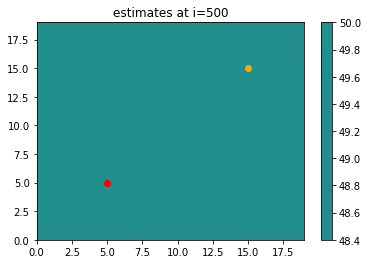

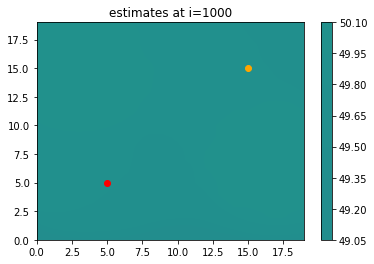

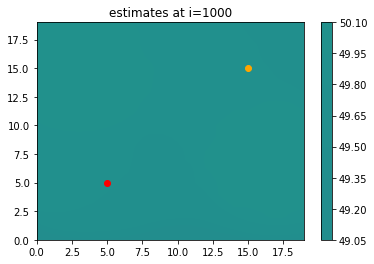

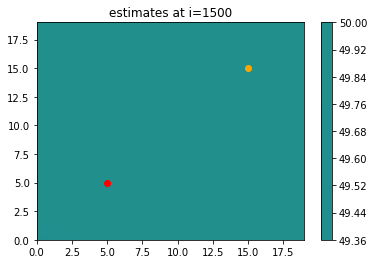

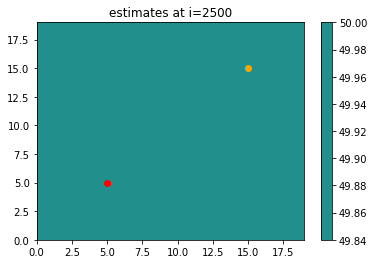

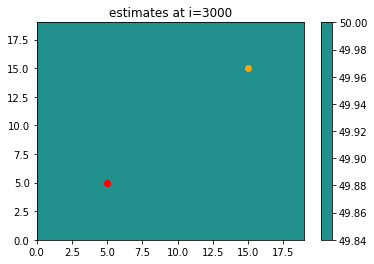

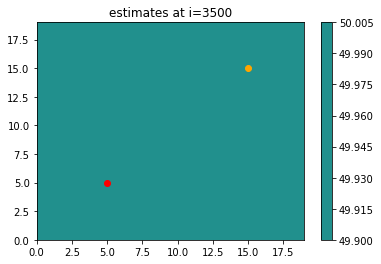

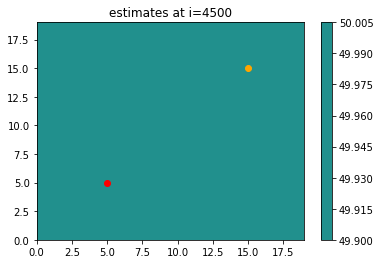

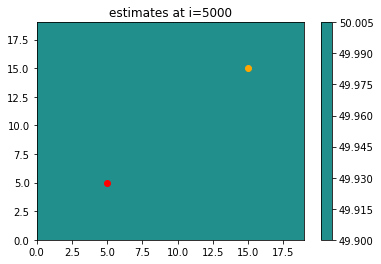

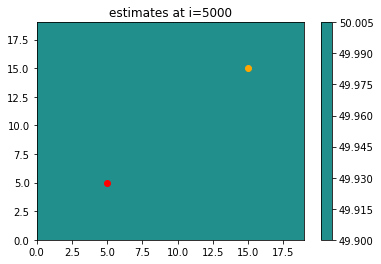

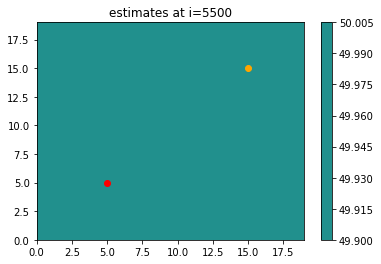

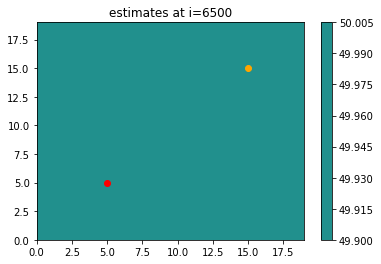

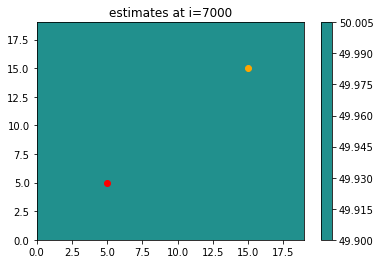

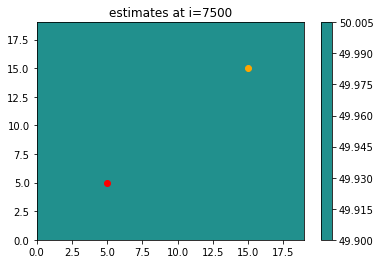

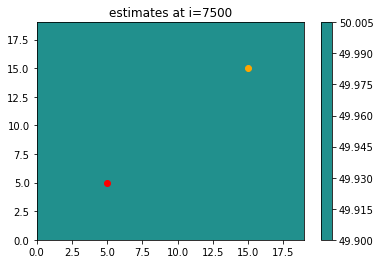

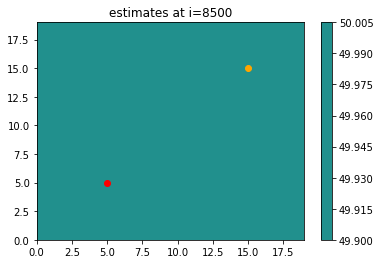

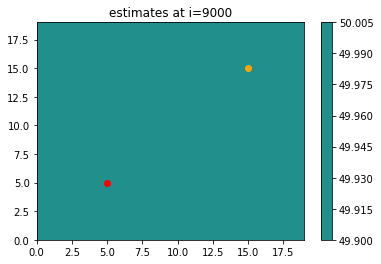

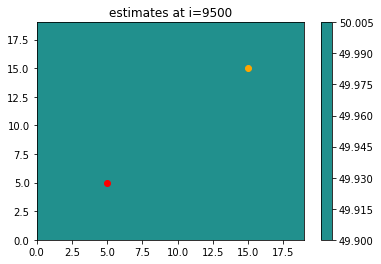

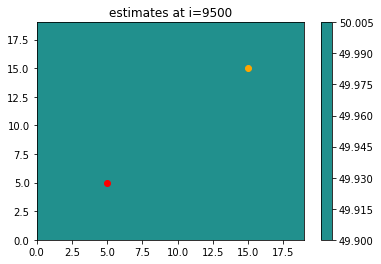

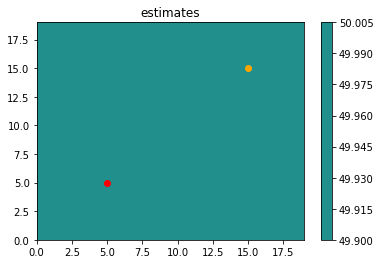

In [14]:
size = 20

# set original params
ogorg = (15,15)
depot = (5,5)

# weight functions
weight_fcn = (lambda w,d: w/ (1 + ( .0001*(1-d) )) )
weight_fcn_aggressive = (lambda w,d: w/ (1 + ( .001*(1-d) )) )

field = big_tester(size, 10001, 5, ogorg, depot, (-1*size/4, size/2), weight_fcn, weight_fcn_aggressive, progress_plot_interval=500)
plot_field(field, og=ogorg, dt=depot, vmin=0, vmax=100)

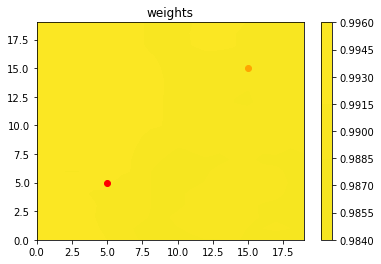

In [15]:
plot_field(field, estimates=False, og=ogorg, dt=depot, vmin=0, vmax=1)

## Try less sensitive weight functions

Estimates appear to be too bouncy. Freeze estimates sooner.

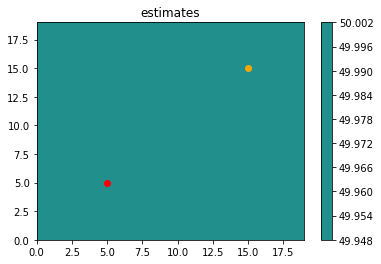

In [16]:
# weight functions
weight_fcn = (lambda w,d: w/ (1 + ( .001*(1-d) )) )
weight_fcn_aggressive = (lambda w,d: w/ (1 + ( .01*(1-d) )) )

field = big_tester(size, 10001, 5, ogorg, depot, (-1*size/4, size/2), weight_fcn, weight_fcn_aggressive, progress_plot_interval=20000)
plot_field(field, og=ogorg, dt=depot, vmin=0, vmax=100)

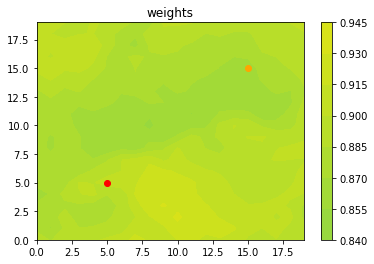

In [17]:
plot_field(field, estimates=False, og=ogorg, dt=depot, vmin=0, vmax=1)

That didn't work.

## Fewer iterations?

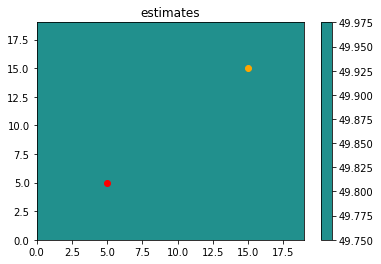

In [18]:
# weight functions
weight_fcn = (lambda w,d: w/ (1 + ( .001*(1-d) )) )
weight_fcn_aggressive = (lambda w,d: w/ (1 + ( .01*(1-d) )) )

field = big_tester(size, 1001, 5, ogorg, depot, (-1*size/4, size/2), weight_fcn, weight_fcn_aggressive, progress_plot_interval=20000)
plot_field(field, og=ogorg, dt=depot, vmin=0, vmax=100)

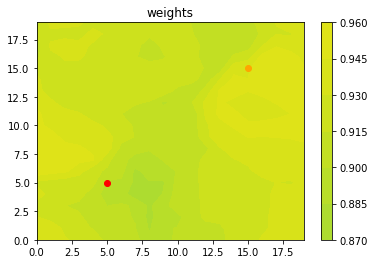

In [19]:
plot_field(field, estimates=False, og=ogorg, dt=depot, vmin=0, vmax=1)

There just isn't enough variation in our cost estimates.

## Fewer rejected requests before reset?

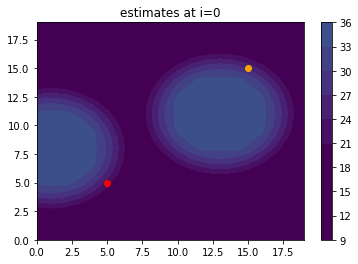

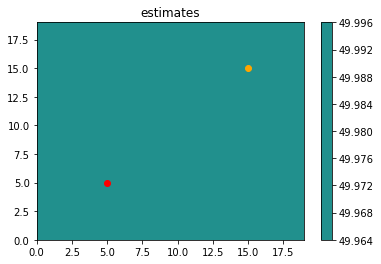

In [20]:
# weight functions
weight_fcn = (lambda w,d: w/ (1 + ( .0001*(1-d) )) )
weight_fcn_aggressive = (lambda w,d: w/ (1 + ( .001*(1-d) )) )

field = big_tester(size, 10001, 2, ogorg, depot, (-1*size/4, size/2), weight_fcn, weight_fcn_aggressive, progress_plot_interval=20000)
plot_field(field, og=ogorg, dt=depot, vmin=0, vmax=100)

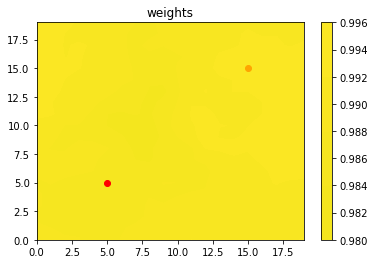

In [21]:
plot_field(field, estimates=False, og=ogorg, dt=depot, vmin=0, vmax=1)

The cost estimates don't look right. What about tossing the reset counter entirely?

## No consecutive matches

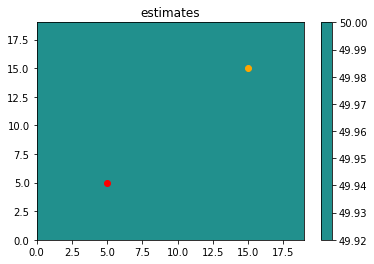

In [22]:
# weight functions
weight_fcn = (lambda w,d: w/ (1 + ( .0001*(1-d) )) )
weight_fcn_aggressive = (lambda w,d: w/ (1 + ( .001*(1-d) )) )

field = big_tester(size, 10001, 0, ogorg, depot, (-1*size/4, size/2), weight_fcn, weight_fcn_aggressive, progress_plot_interval=20000)
plot_field(field, og=ogorg, dt=depot, vmin=0, vmax=100)

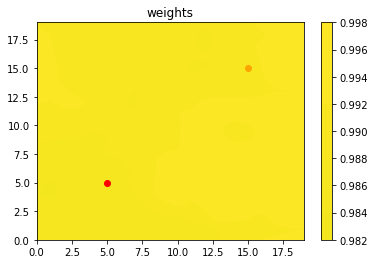

In [23]:
plot_field(field, estimates=False, og=ogorg, dt=depot, vmin=0, vmax=1)

Estimate field still doesn't vary enough/as expected.

# Conclusions

No idea. Spitball guess with little confidence is that the current model is too sensitive to new costs, in a way that just tweaking the weight functions doesn't necessarily solve.